In [2]:
import json
import glob
import os
import pandas as pd
import numpy as np
from scipy import stats
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from scipy.stats import ttest_ind

import dlib
import cv2

# Preparation

In [5]:
all_images = {}
i = 0
for file_path in glob.glob('../dataset_faces/*.png'):
    file_name = os.path.basename(file_path)
    key = i
    i += 1
    all_images[key] = '../dataset_faces/'+file_name

In [6]:
images = []
for i in range(len(all_images)):
    image = Image.open(all_images[i])
    image = image.convert('RGB')
    image = np.array(image)
    images.append(image)

## Face detection

In [7]:
face_detector = dlib.get_frontal_face_detector()
face_predictor = dlib.shape_predictor("../model/shape_predictor_68_face_landmarks.dat") 


In [8]:
landmarks = []
indeces = []
for i in range(len(images)):
    image = images[i]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    face = face_detector(gray, 1)
    if len(face) > 0:
        indeces.append(i)
        landmark = face_predictor(gray, face[0])
        landmarks.append(landmark)

In [9]:
len(indeces)

50

In [10]:
mark_xs = []
mark_ys = []
for i in range(len(landmarks)):
    landmark = landmarks[i]
    mark_x = (landmark.part(19).x + landmark.part(24).x) / 2
    mark_y = 2 * landmark.part(19).y - (landmark.part(51).y + landmark.part(33).y)/2
    mark_xs.append(mark_x)
    mark_ys.append(mark_y)

## Segment Ushnisha

In [11]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [12]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "../model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

predictor = SamPredictor(sam)

/Users/lyla/Inpaint-Anything/segment_anything/segment_anything/modeling/tiny_vit_sam.py:657: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/lyla/Inpaint-Anything/segment_anything/segment_anything/modeling/tiny_vit_sam.py:657: UserWarning: Overwriting tiny_vit_11m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/lyla/Inpaint-Anything/segment_anything/segment_anything/modeling/tiny_vit_sam.py:657: UserWarning: Overwriting tiny_vit_21m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Pl

In [13]:
def mask_to_image(i, j, mask, random_color=False):
    color = np.array([30/255, 144/255, 255/255,0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    # plt.imsave('../result_imgs/' + str(i) + str(j) + '.png', mask_image)
    return mask_image

In [23]:
for i in range(len(indeces)):
    image = images[indeces[i]]
    predictor.set_image(image)
    input_point = np.array([[mark_xs[i], mark_ys[i]]])
    input_label = np.array([1])
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    for j, (mask, score) in enumerate(zip(masks, scores)):
        result = np.copy(image)
        mask_image = mask_to_image(i, j, mask)
        result[mask_image[:, :, 3] > 0] = 255

        plt.imsave('../Res_Images/' + str(indeces[i]) +'-'+ all_images[indeces[i]].split('-')[3] +'-' + str(j) + '.png', result)
        np.save('../Res_Masks/' + str(indeces[i]) + '-'+ all_images[indeces[i]].split('-')[3] + '-' + str(j) + '.npy', mask)

    

## Use selected results

In [3]:
image_folder = "../Res_select_images"
mask_folder = "../Res_Masks"

masks_selected = []
indecies = []
for image_file in os.listdir(image_folder):
    if image_file.endswith('.png'):
        index = image_file.split('.')[0]

        indecies.append(index)
        mask_file = os.path.join(mask_folder, str(index) + '.npy')

        if os.path.exists(mask_file):
            masks_selected.append(np.load(mask_file))


In [4]:
NorthernQi = []
NorthernWei = []
for i in range(len(indecies)):
    name = indecies[i]
    if name.split('-')[1] == 'NorthernQi':
        NorthernQi.append(i)
    else:
        NorthernWei.append(i)

In [5]:
print("The dataset size of Northern Qi:" + str(len(NorthernQi)))
print("The dataset size of Northern Wei:" + str(len(NorthernWei)))

The dataset size of Northern Qi:33
The dataset size of Northern Wei:10


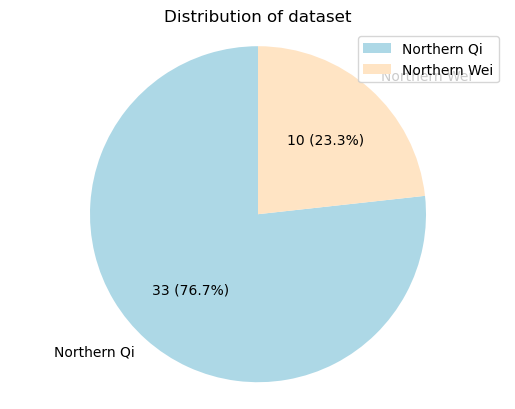

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

data = {'Class': ['Northern Qi', 'Northern Wei'],
        'Count': [33, 10]} 
df = pd.DataFrame(data)

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{val} ({pct:.1f}%)'
    return my_format

df.set_index('Class').plot.pie(y='Count', autopct=autopct_format(df['Count']), startangle=90, colors=['lightblue', 'bisque'])

plt.title('Distribution of dataset')

plt.ylabel('') 
plt.axis('equal')
plt.show()


# Analysis

## Ratio Analysis

In [7]:
def cal_mask_ratio(mask, draw = False):
    # Find indices of marked pixels (True values) in the mask
    rows, cols = np.where(mask)

    if len(rows) == 0 or len(cols) == 0:
        # If no marked pixels found, return
        return

    minx = np.min(cols)
    maxx = np.max(cols)

    # Calculate bounding box coordinates
    y_min = np.min(rows)
    x_min, x_max = np.min(cols), np.max(cols)

    index = np.argmin(rows)
    y_max = np.max(rows[np.where(cols == cols[index])])

    mask[y_max+1:, :] = False

    # rows, cols = np.where(mask)
    
    if draw:
        # Plot the marked points
        plt.figure(figsize=(6, 6))  # Set the figure size as desired
        plt.scatter(cols, rows, s=5, color='blue') 
        # Draw the bounding box
        plt.plot([x_min, x_max], [y_min, y_min], color='red', linewidth=2)  # Top line
        plt.plot([x_min, x_max], [y_max, y_max], color='red', linewidth=2)  # Bottom line
        plt.plot([x_min, x_min], [y_min, y_max], color='red', linewidth=2)  # Left line
        plt.plot([x_max, x_max], [y_min, y_max], color='red', linewidth=2)  # Right line

        # Customize plot appearance
        plt.title('Shape of Mask')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.gca().invert_yaxis()  # Invert y-axis to match typical image coordinate system
        plt.grid(True)

        # Show plot
        plt.show()
        
    H = y_max - y_min
    W = x_max - x_min
    return H, W

In [8]:
Qi_ratio = []
for i in range(len(NorthernQi)):
    mask = masks_selected[NorthernQi[i]]
    H, W = cal_mask_ratio(mask)
    ratio = H / W
    Qi_ratio.append(ratio)

In [9]:
Wei_ratio = []
for i in range(len(NorthernWei)):
    mask = masks_selected[NorthernWei[i]]
    H, W = cal_mask_ratio(mask)
    ratio = H / W
    Wei_ratio.append(ratio)

Mean:
T-statistic: -8.123521379524531
P-value: 4.4890894332903153e-10


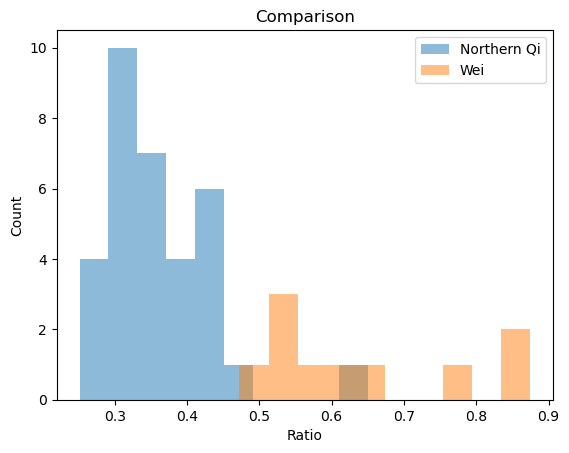

In [10]:
plt.hist(Qi_ratio, bins=10, alpha=0.5, label='Northern Qi')
plt.hist(Wei_ratio, bins=10, alpha=0.5, label='Wei')

t_statistic, p_value = ttest_ind(Qi_ratio, Wei_ratio)
print("Mean:")
print("T-statistic:", t_statistic)
print("P-value:", p_value)

plt.title('Comparison')
plt.xlabel('Ratio')
plt.ylabel('Count')
plt.legend(loc='upper right')


## Curvature Analysis

### Edge detection

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours

def calculate_edge_points(mask):
    rows, cols = np.where(mask)

    if len(rows) == 0 or len(cols) == 0:
        return np.array([]), np.array([])

    contours = find_contours(mask.astype(float), 0.5)

    if len(contours) == 0:
        return np.array([]), np.array([])

    contour = max(contours, key=len)

    contour_rows = contour[:, 0]
    contour_cols = contour[:, 1]

    return contour_rows, contour_cols

### Select the top side

In [12]:
def select_top_curve_part(rows, cols):
    # Find the topmost point
    top_index = np.argmin(cols)

    # Split the curve into two parts at the topmost point
    top_part_rows = rows[top_index+1:]
    top_part_cols = cols[top_index+1:]

    return top_part_rows, top_part_cols

In [13]:
Qi_curves_rows = []
Qi_curves_cols = []
Wei_curves_rows = []
Wei_curves_cols = []

for i in range(len(NorthernQi)):
    mask = masks_selected[NorthernQi[i]]
    rows, cols = calculate_edge_points(mask)
    top_part_rows, top_part_cols = select_top_curve_part(rows, cols)
    # plt.plot(top_part_cols, top_part_rows, 'r-', label='Top Part of Curve')
    Qi_curves_rows.append(top_part_rows)
    Qi_curves_cols.append(top_part_cols)

for i in range(len(NorthernWei)):
    mask = masks_selected[NorthernWei[i]]
    rows, cols = calculate_edge_points(mask)
    top_part_rows, top_part_cols = select_top_curve_part(rows, cols)
    # plt.plot(top_part_cols, top_part_rows, 'r-', label='Top Part of Curve')
    Wei_curves_rows.append(top_part_rows)
    Wei_curves_cols.append(top_part_cols)


### Smooth edges

In [14]:
from scipy.interpolate import splprep, splev

def smooth_contour(contour_rows, contour_cols, smoothness=50):
    # Fit spline to the contour points
    tck, u = splprep([contour_rows, contour_cols], s=smoothness)
    u_new = np.linspace(u.min(), u.max(), len(contour_rows) * 10)
    contour_rows_smooth, contour_cols_smooth = splev(u_new, tck)

    return np.array(contour_rows_smooth), np.array(contour_cols_smooth)

Qi_curves_rows_smoothed = []
Qi_curves_cols_smoothed = []
Wei_curves_rows_smoothed = []
Wei_curves_cols_smoothed = []

for idx in range(len(Qi_curves_rows)):
    contour_rows = Qi_curves_rows[idx]
    contour_cols = Qi_curves_cols[idx]

    contour_rows_smooth, contour_cols_smooth = smooth_contour(contour_rows, contour_cols)
    Qi_curves_rows_smoothed.append(contour_rows_smooth)
    Qi_curves_cols_smoothed.append(contour_cols_smooth)

for idx in range(len(Wei_curves_rows)):
    contour_rows = Wei_curves_rows[idx]
    contour_cols = Wei_curves_cols[idx]

    contour_rows_smooth, contour_cols_smooth = smooth_contour(contour_rows, contour_cols)
    Wei_curves_rows_smoothed.append(contour_rows_smooth)
    Wei_curves_cols_smoothed.append(contour_cols_smooth)

### Curvature

In [15]:
Qi_curvatures = []
Wei_curvatures = []

for i in range(len(Qi_curves_rows_smoothed)):
    rows = Qi_curves_rows_smoothed[i]
    cols = Qi_curves_cols_smoothed[i]
    x, y = rows.copy(), cols.copy()

    dx = np.gradient(x)
    dy = np.gradient(y)
    d2x = np.gradient(dx)
    d2y = np.gradient(dy)

    # Compute curvature using the formula: curvature = (dx * d2y - dy * d2x) / (dx^2 + dy^2)^(3/2)
    curvature = (dx * d2y - dy * d2x) / (dx**2 + dy**2)**(3/2)
    Qi_curvatures.append(curvature)

for i in range(len(Wei_curves_rows_smoothed)):
    rows = Wei_curves_rows_smoothed[i]
    cols = Wei_curves_cols_smoothed[i]
    x, y = rows.copy(), cols.copy()

    dx = np.gradient(x)
    dy = np.gradient(y)
    d2x = np.gradient(dx)
    d2y = np.gradient(dy)

    # Compute curvature using the formula: curvature = (dx * d2y - dy * d2x) / (dx^2 + dy^2)^(3/2)
    curvature = (dx * d2y - dy * d2x) / (dx**2 + dy**2)**(3/2)
    Wei_curvatures.append(curvature)

### Comparisons

Mean:
T-statistic: -3.0807305230548634
P-value: 0.0036798583549164806
Standard Deviation:
T-statistic: -2.9290597482811123
P-value: 0.005530600861764241


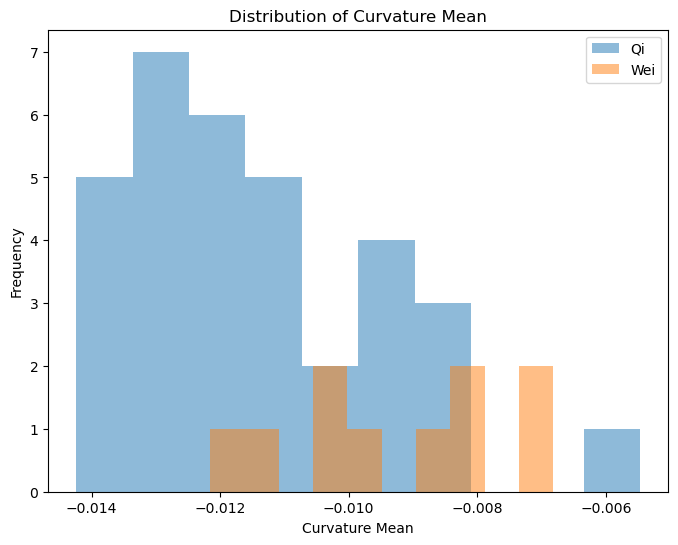

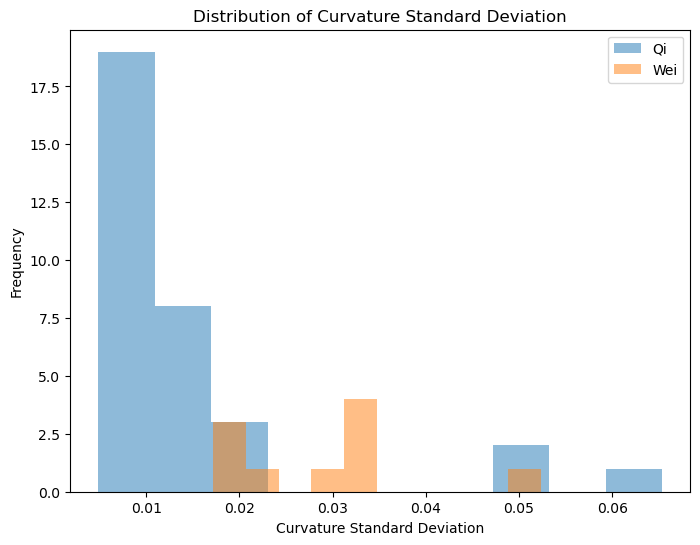

In [16]:
type1_list = Qi_curvatures.copy()
type2_list = Wei_curvatures.copy()


def extract_mean(array):
    mean_value = np.mean(array)
    return mean_value
def extract_std(array):
    std_deviation = np.std(array)
    return std_deviation

type1_features_mean = [extract_mean(array) for array in type1_list]
type2_features_mean = [extract_mean(array) for array in type2_list]
type1_features_std = [extract_std(array) for array in type1_list]
type2_features_std = [extract_std(array) for array in type2_list]


t_statistic, p_value = ttest_ind(type1_features_mean, type2_features_mean)
print("Mean:")
print("T-statistic:", t_statistic)
print("P-value:", p_value)

t_statistic, p_value = ttest_ind(type1_features_std, type2_features_std)
print("Standard Deviation:")
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Step 3: Visualization
plt.figure(figsize=(8, 6))
plt.hist(type1_features_mean, bins=10, alpha=0.5, label='Qi')
plt.hist(type2_features_mean, bins=10, alpha=0.5, label='Wei')
plt.xlabel('Curvature Mean')
plt.ylabel('Frequency')
plt.title('Distribution of Curvature Mean')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(type1_features_std, bins=10, alpha=0.5, label='Qi')
plt.hist(type2_features_std, bins=10, alpha=0.5, label='Wei')
plt.xlabel('Curvature Standard Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Curvature Standard Deviation')
plt.legend()
plt.show()


## Visualize

In [29]:
Qi_curves_cols_normalized = [(array - np.mean(array))/(np.max(array) - np.min(array)) for array in Qi_curves_cols_smoothed]
Qi_curves_rows_normalized = [(array - np.mean(array))/(np.max(array) - np.min(array)) for array in Qi_curves_rows_smoothed]
Wei_curves_cols_normalized = [(array - np.mean(array))/(np.max(array) - np.min(array)) for array in Wei_curves_cols_smoothed]
Wei_curves_rows_normalized = [(array - np.mean(array))/(np.max(array) - np.min(array)) for array in Wei_curves_rows_smoothed]


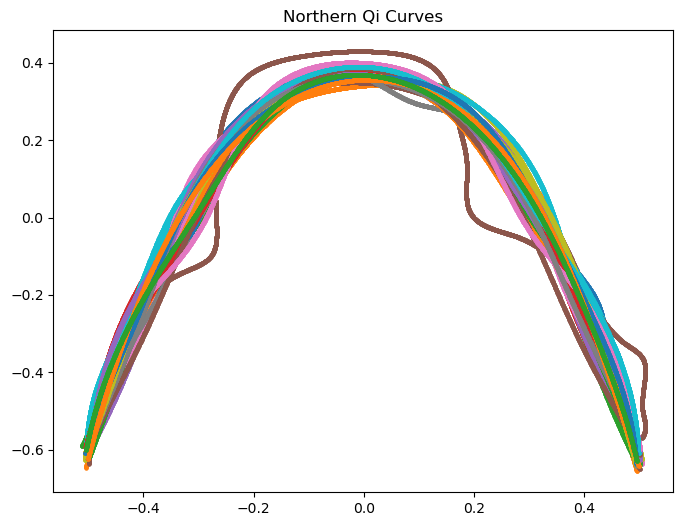

In [30]:
plt.figure(figsize=(8, 6))
for i in range(len(Qi_curves_cols_normalized)):
    plt.scatter(Qi_curves_cols_normalized[i], -Qi_curves_rows_normalized[i], s=5)
    plt.title('Northern Qi Curves')
plt.show()

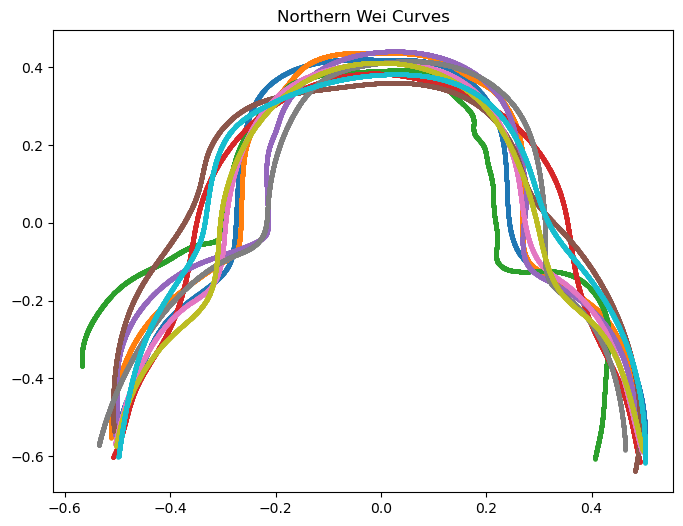

In [31]:
plt.figure(figsize=(8, 6))
for i in range(len(Wei_curves_cols_normalized)):
    plt.scatter(Wei_curves_cols_normalized[i], -Wei_curves_rows_normalized[i], s=5)
    plt.title('Northern Wei Curves')
plt.show()

In [19]:
cols_max = 0
cols_min = 10000
rows_max = 0
rows_min = 10000
for array in Qi_curves_cols_smoothed:
    cols_max = max(cols_max, np.max(array))
    cols_min = min(cols_min, np.min(array))
for array in Qi_curves_rows_smoothed:
    rows_max = max(rows_max, np.max(array))
    rows_min = min(rows_min, np.min(array))
for array in Wei_curves_cols_smoothed:
    cols_max = max(cols_max, np.max(array))
    cols_min = min(cols_min, np.min(array))
for array in Wei_curves_rows_smoothed:
    rows_max = max(rows_max, np.max(array))
    rows_min = min(rows_min, np.min(array))
rows_scale = rows_max - rows_min
cols_scale = cols_max - cols_min

In [21]:
Qi_curves_cols_normalized = [(array - np.mean(array))/cols_scale for array in Qi_curves_cols_smoothed]
Qi_curves_rows_normalized = [(array - np.mean(array))/rows_scale for array in Qi_curves_rows_smoothed]
Wei_curves_cols_normalized = [(array - np.mean(array))/cols_scale for array in Wei_curves_cols_smoothed]
Wei_curves_rows_normalized = [(array - np.mean(array))/rows_scale for array in Wei_curves_rows_smoothed]


In [34]:
x_lim = 0.5
y_lim = 0.5

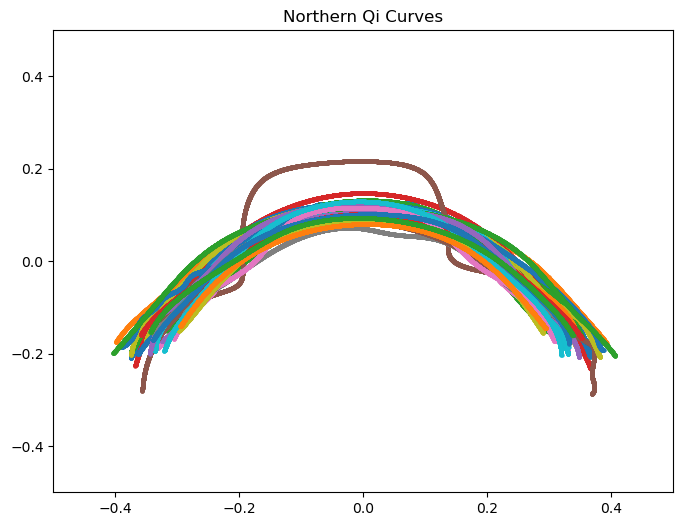

In [35]:
plt.figure(figsize=(8, 6))
for i in range(len(Qi_curves_cols_normalized)):
    plt.scatter(Qi_curves_cols_normalized[i], -Qi_curves_rows_normalized[i], s=5)
    plt.title('Northern Qi Curves')
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.show()

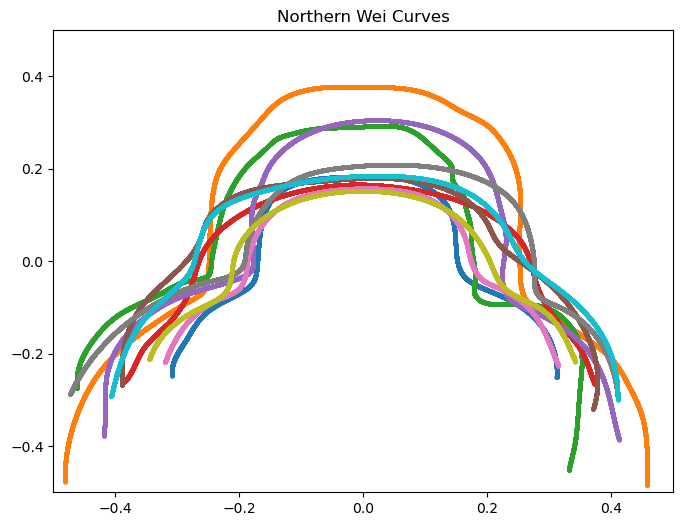

In [36]:
plt.figure(figsize=(8, 6))
for i in range(len(Wei_curves_cols_normalized)):
    plt.scatter(Wei_curves_cols_normalized[i], -Wei_curves_rows_normalized[i], s=5)
    plt.title('Northern Wei Curves')
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.show()